Projet_Python

# 1)Collect des avis de sécurité ANSSI 

---

## Objectif

Ce notebook a pour objectif de :
- récupérer les **avis de sécurité ANSSI** via le flux RSS,
- explorer leur contenu,
- préparer l’enrichissement avec les bases **MITRE (CVE)** et **EPSS**.

Le notebook sert de **phase exploratoire et de validation** avant intégration dans un script Python final.


##  Présentation du collecteur

Nous utilisons une classe `Collector` qui centralise :
- la récupération du flux RSS ANSSI,
- les appels API externes (MITRE, EPSS),
- la gestion des requêtes HTTP.

Cette approche permet de garder un code **modulaire et réutilisable**.


In [26]:
import feedparser
import requests
from typing import List, Dict, Any, Set


In [27]:

class Collector:
    rss_url = "https://www.cert.ssi.gouv.fr/avis/feed/"
    timeout = 5

    @staticmethod
    def get_rss_entries(url) -> feedparser.util.FeedParserDict:
        print(f"Récupération du flux RSS: {url}")
        rss_feed = feedparser.parse(url)
        print(f"Flux RSS récupéré: {len(rss_feed.entries)} entrées disponibles")
        return rss_feed.entries

    @staticmethod
    def fetch_json(url: str) -> Dict[str, Any]:
        r = requests.get(url, timeout=Collector.timeout)
        r.raise_for_status()
        return r.json()

    @staticmethod
    def fetch_mitre(cve_id: str) -> Dict[str, Any]:
        url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        r = requests.get(url, timeout=Collector.timeout)
        r.raise_for_status()
        return r.json()

    @staticmethod
    def fetch_epss(cve_id: str) -> Dict[str, Any]:
        url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
        r = requests.get(url, timeout=Collector.timeout)
        r.raise_for_status()
        return r.json()

## 2)Enrichissement des CVE (MITRE & EPSS)

Cette section est dédiée à l’enrichissement des identifiants CVE extraits
des avis ANSSI.

L’enrichissement repose sur :
- la base officielle **MITRE (CVE)** pour les descriptions, scores CVSS, CWE et produits affectés ;
- la base **EPSS** pour estimer la probabilité d’exploitation.

L’objectif est d’obtenir une vision **technique et priorisée** des vulnérabilités.


In [28]:
from typing import List, Dict, Any, Set
import feedparser
import requests
import re


In [29]:
class Enrichment:
    """
    Explorer
    --------
    - Extract CVEs from CERT-FR RSS feeds
    - Enrich CVEs with MITRE & EPSS data
    """

    def __init__(
        self,
        enrich_limit: int = 10,
        timeout: int = 10,
    ) -> None:
        self.enrich_limit = enrich_limit
        self.timeout = timeout

    # ---------------------------
    # Enrichment (MITRE / EPSS)
    # ---------------------------
    
    def enrich_cve(self, cve_id: str) -> Dict[str, Any]:
        description: str = "Non disponible"
        cvss_score: str | float = "Non disponible"
        cwe: str = "Non disponible"
        epss_score: str | float = "Non disponible"
        severity: str = "Non disponible"
        products: List[Dict[str, Any]] = []

        # --- MITRE ---
        try:
            print(f" Récupération MITRE pour {cve_id}...")
            mitre = Collector.fetch_mitre(cve_id)
            cna = mitre["containers"]["cna"]

            descs = cna.get("descriptions", [])
            if descs:
                description = descs[0].get("value", description)

            metrics = cna.get("metrics", [])
            if metrics:
                m0 = metrics[0]
                if "cvssV3_1" in m0:
                    cvss_score = m0["cvssV3_1"].get("baseScore", cvss_score)
                    severity = m0["cvssV3_1"].get("baseSeverity", severity)
                elif "cvssV3_0" in m0:
                    cvss_score = m0["cvssV3_0"].get("baseScore", cvss_score)
                    severity = m0["cvssV3_0"].get("baseSeverity", severity)

            problemtype = cna.get("problemTypes", [])
            if problemtype and problemtype[0].get("descriptions"):
                cwe = problemtype[0]["descriptions"][0].get("cweId", cwe)

            # Extraction des produits affectés
            affected = cna.get("affected", [])
            for aff in affected:
                vendor = aff.get("vendor", "N/A")
                product = aff.get("product", "N/A")
                versions = []
                for v in aff.get("versions", []):
                    version_str = v.get("version", "")
                    if version_str:
                        versions.append(version_str)
                products.append({
                    "vendor": vendor,
                    "product": product,
                    "versions": versions
                })
            print(f" MITRE récupéré (CVSS: {cvss_score}, Severity: {severity})")

        except Exception as e:
            print(f"    Erreur MITRE: {e}")

        # --- EPSS ---
        try:
            print(f" Récupération EPSS pour {cve_id}...")
            epss = Collector.fetch_epss(cve_id)
            data = epss.get("data", [])
            if data:
                epss_score = data[0].get("epss", epss_score)
            print(f"    EPSS récupéré: {epss_score}")
        except Exception as e:
            print(f"    Erreur EPSS: {e}")

        return {
            "cve": cve_id,
            "description": description,
            "cvss": cvss_score,
            "severity": severity,
            "cwe": cwe,
            "epss": epss_score,
            "products": products if products else [{"vendor": "N/A", "product": "N/A", "versions": []}],
        }

### Test d’enrichissement d’une CVE

Nous testons l’enrichissement sur une CVE connue afin de valider :
- la récupération MITRE,
- le score EPSS,
- la structure des données retournées.


In [30]:
enricher = Enrichment()

result = enricher.enrich_cve("CVE-2023-34362")
result


 Récupération MITRE pour CVE-2023-34362...
 MITRE récupéré (CVSS: Non disponible, Severity: Non disponible)
 Récupération EPSS pour CVE-2023-34362...
    EPSS récupéré: 0.942540000


{'cve': 'CVE-2023-34362',
 'description': "In Progress MOVEit Transfer before 2021.0.6 (13.0.6), 2021.1.4 (13.1.4), 2022.0.4 (14.0.4), 2022.1.5 (14.1.5), and 2023.0.1 (15.0.1), a SQL injection vulnerability has been found in the MOVEit Transfer web application that could allow an unauthenticated attacker to gain access to MOVEit Transfer's database. Depending on the database engine being used (MySQL, Microsoft SQL Server, or Azure SQL), an attacker may be able to infer information about the structure and contents of the database, and execute SQL statements that alter or delete database elements. NOTE: this is exploited in the wild in May and June 2023; exploitation of unpatched systems can occur via HTTP or HTTPS. All versions (e.g., 2020.0 and 2019x) before the five explicitly mentioned versions are affected, including older unsupported versions.",
 'cvss': 'Non disponible',
 'severity': 'Non disponible',
 'cwe': 'Non disponible',
 'epss': '0.942540000',
 'products': [{'vendor': 'n/a'

### Analyse des résultats

Les données enrichies permettent :
- d’évaluer la **sévérité technique** (CVSS),
- d’identifier la **probabilité d’exploitation** (EPSS),
- de cibler les **produits impactés**.

Ces informations seront utilisées pour :
- prioriser les vulnérabilités,
- produire des exports (CSV / JSON),
- alimenter un tableau de bord.


## 3 )Création du DataFrame
- créer un DataFrame pandas



In [31]:
import pandas as pd
from utils import to_json_url
from collect import Collector
from extract import Extractor
from enrich import Enrichment


In [32]:
def build_dataframe(rss_url, bulletin_type, enrichment: Enrichment, limit=5):
    rows = []
    entries = Collector.get_rss_entries(rss_url)
    print(f"\nNombre total d'entrées RSS récupérées: {len(entries)}")
    print(f"Limite appliquée: {limit} entrées\n")

    for idx, entry in enumerate(entries[:limit], 1):
        print(f"\n{'='*80}")
        print(f"Traitement du bulletin {idx}/{limit}: {entry.title}")
        print(f"{'='*80}")
        
        # Extraire les CVE pour cette entrée spécifique
        json_url = to_json_url(entry.link)
        print(f"URL JSON: {json_url}")
        
        try:
            print(f"Récupération des données JSON...")
            data = Collector.fetch_json(json_url)
            print(f"Données récupérées")
            
            # Récupérer l'ID ANSSI
            anssi_id = data.get("reference", "N/A")
            
            print(f"Extraction des CVE...")
            cves = Extractor.extract_cves_from_bulletin(data)
            print(f"{len(cves)} CVE trouvées: {cves}")
        except Exception as e:
            print(f"Erreur lors de l'extraction pour {entry.title}: {e}")
            continue

        for cve_idx, cve in enumerate(cves, 1):
            print(f"\n  Enrichissement CVE {cve_idx}/{len(cves)}: {cve}")
            info = enrichment.enrich_cve(cve)
            print(f"  CVE {cve} enrichie (CVSS: {info['cvss']}, EPSS: {info['epss']})")

            products = info["products"] or [{"vendor": "N/A", "product": "N/A", "versions": []}]

            for p in products:
                rows.append({
                    "ID ANSSI": anssi_id,
                    "Titre bulletin (ANSSI)": entry.title,
                    "Type bulletin": bulletin_type,
                    "Date publication": getattr(entry, "published", None),
                    "Identifiant CVE": cve,
                    "Score CVSS": info["cvss"],
                    "Base Severity": info["severity"],
                    "Type CWE": info["cwe"],
                    "Score EPSS": info["epss"],
                    "Lien bulletin (ANSSI)": entry.link,
                    "Description": info["description"],
                    "Éditeur/Vendor": p["vendor"],
                    "Produit": p["product"],
                    "Versions affectées": ", ".join(p["versions"])
                })

    print(f"\n{'='*80}")
    print(f"Traitement terminé! {len(rows)} lignes générées")
    print(f"{'='*80}\n")
    return pd.DataFrame(rows)

## 4)Export CSV
- exporter le résultat en CSV

In [33]:
# Initialisation de l'enrichisseur
enricher = Enrichment()

# Construire DataFrame
df = build_dataframe(
    rss_url=Collector.rss_url,
    bulletin_type="Avis de sécurité",
    enrichment=enricher,
    limit=25  # Ajuster selon besoin
)

# Export CSV
csv_file = "cves_consolides.csv"
df.to_csv(csv_file, index=False)
print(f"CSV '{csv_file}' créé avec {len(df)} lignes")


Récupération du flux RSS: https://www.cert.ssi.gouv.fr/avis/feed/
Flux RSS récupéré: 40 entrées disponibles

Nombre total d'entrées RSS récupérées: 40
Limite appliquée: 25 entrées


Traitement du bulletin 1/25: Multiples vulnérabilités dans les produits Microsoft (09 janvier 2026)
URL JSON: https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-AVI-0022/json/
Récupération des données JSON...
Données récupérées
Extraction des CVE...
2 CVE trouvées: ['CVE-2025-11961', 'CVE-2025-11964']

  Enrichissement CVE 1/2: CVE-2025-11961
    Récupération MITRE pour CVE-2025-11961...
MITRE récupéré (CVSS: 1.9, Severity: LOW)
    Récupération EPSS pour CVE-2025-11961...
EPSS récupéré: 0.000150000
  CVE CVE-2025-11961 enrichie (CVSS: 1.9, EPSS: 0.000150000)

  Enrichissement CVE 2/2: CVE-2025-11964
    Récupération MITRE pour CVE-2025-11964...
MITRE récupéré (CVSS: 1.9, Severity: LOW)
    Récupération EPSS pour CVE-2025-11964...
EPSS récupéré: 0.000150000
  CVE CVE-2025-11964 enrichie (CVSS: 1.9, EPSS: 0.00015

## 5)Exploration et statistique du DataFrame

Nous allons maintenant explorer le fichier CSV pour :
- vérifier la structure des données,
- détecter les valeurs manquantes,
- préparer les visualisations.


In [34]:
# Chargement CSV
df = pd.read_csv(csv_file)


In [35]:
df.head()

,ID ANSSI,Titre bulletin (ANSSI),Type bulletin,Date publication,Identifiant CVE,Score CVSS,Base Severity,Type CWE,Score EPSS,Lien bulletin (ANSSI),Description,Éditeur/Vendor,Produit,Versions affectées
0,CERTFR-2026-AVI-0022,Multiples vulnérabilités dans les produits Mic...,Avis de sécurité,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-11961,1.9,LOW,CWE-126,0.000150000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,pcap_ether_aton() is an auxiliary function in ...,The Tcpdump Group,libpcap,0
1,CERTFR-2026-AVI-0022,Multiples vulnérabilités dans les produits Mic...,Avis de sécurité,"Fri, 09 Jan 2026 00:00:00 +0000",CVE-2025-11964,1.9,LOW,CWE-787,0.000150000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"On Windows only, if libpcap needs to convert a...",The Tcpdump Group,libpcap,1.10.0
2,CERTFR-2026-AVI-0023,Multiples vulnérabilités dans les produits Axi...,Avis de sécurité,"Mon, 12 Jan 2026 00:00:00 +0000",CVE-2024-47262,5.3,MEDIUM,CWE-1287,0.001520000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,"Dzmitry Lukyanenka, member of the AXIS OS Bug ...",Axis Communications AB,AXIS OS,"6.50.0, 7.0.0, 9.0.0, 10.0.0, 11.0.0, 12.0.0"
3,CERTFR-2026-AVI-0023,Multiples vulnérabilités dans les produits Axi...,Avis de sécurité,"Mon, 12 Jan 2026 00:00:00 +0000",CVE-2025-30025,Non disponible,Non disponible,CWE-502,0.000370000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,The communication protocol used between the\ns...,Axis Communications AB,AXIS Device Manager,<5.32
4,CERTFR-2026-AVI-0023,Multiples vulnérabilités dans les produits Axi...,Avis de sécurité,"Mon, 12 Jan 2026 00:00:00 +0000",CVE-2025-30025,Non disponible,Non disponible,CWE-502,0.000370000,https://www.cert.ssi.gouv.fr/avis/CERTFR-2026-...,The communication protocol used between the\ns...,Axis Communications AB,AXIS Camera Station Pro,<6.8


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1787 entries, 0 to 1786
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID ANSSI                1787 non-null   object
 1   Titre bulletin (ANSSI)  1787 non-null   object
 2   Type bulletin           1787 non-null   object
 3   Date publication        1787 non-null   object
 4   Identifiant CVE         1787 non-null   object
 5   Score CVSS              1787 non-null   object
 6   Base Severity           1787 non-null   object
 7   Type CWE                1787 non-null   object
 8   Score EPSS              1787 non-null   object
 9   Lien bulletin (ANSSI)   1787 non-null   object
 10  Description             1787 non-null   object
 11  Éditeur/Vendor          1754 non-null   object
 12  Produit                 1754 non-null   object
 13  Versions affectées      1753 non-null   object
dtypes: object(14)
memory usage: 195.6+ KB


In [37]:
df.shape[0]   # nombre de lignes

1787

In [38]:
df.shape[1]   # nombre de colonnes

14

In [39]:
stats = pd.DataFrame({
    "Type": df.dtypes,
    "Valeurs non nulles": df.notna().sum(),
    "Valeurs nulles": df.isna().sum(),
    "% remplissage": (1 - df.isna().mean()) * 100
})
stats

,Type,Valeurs non nulles,Valeurs nulles,% remplissage
ID ANSSI,object,1787,0,100.00000
Titre bulletin (ANSSI),object,1787,0,100.00000
Type bulletin,object,1787,0,100.00000
Date publication,object,1787,0,100.00000
Identifiant CVE,object,1787,0,100.00000
Score CVSS,object,1787,0,100.00000
Base Severity,object,1787,0,100.00000
Type CWE,object,1787,0,100.00000
Score EPSS,object,1787,0,100.00000
Lien bulletin (ANSSI),object,1787,0,100.00000


# 6)Visualisations et analyses

Nous analysons :
- la distribution CVSS,
- la répartition par sévérité,
- les produits / éditeurs les plus touchés,
- relation CVSS vs EPSS,
- évolution temporelle des bulletins.


In [40]:
# -----------------------
# Imports
# -----------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# -----------------------
# Chargement des données
# -----------------------
CSV_FILE = "cves_consolides.csv"
df = pd.read_csv(CSV_FILE)

print("Nombre total de lignes :", len(df))
print("Colonnes :", list(df.columns))

# Nettoyage minimal
df["Score CVSS"] = pd.to_numeric(df["Score CVSS"], errors="coerce")
df["Score EPSS"] = pd.to_numeric(df["Score EPSS"], errors="coerce")

Nombre total de lignes : 1787
Colonnes : ['ID ANSSI', 'Titre bulletin (ANSSI)', 'Type bulletin', 'Date publication', 'Identifiant CVE', 'Score CVSS', 'Base Severity', 'Type CWE', 'Score EPSS', 'Lien bulletin (ANSSI)', 'Description', 'Éditeur/Vendor', 'Produit', 'Versions affectées']


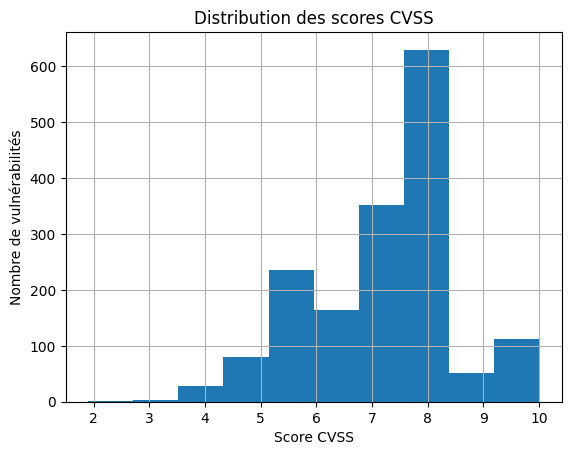

In [42]:
# -----------------------
# 1) Histogramme CVSS
# -----------------------

plt.figure()
df["Score CVSS"].dropna().hist(bins=10)
plt.title("Distribution des scores CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.show()


**Interprétation** : Ce graphique montre la distribution des scores CVSS (Common Vulnerability Scoring System) parmi les vulnérabilités analysées. Le CVSS mesure la sévérité technique d'une vulnérabilité sur une échelle de 0 à 10. Une concentration dans les scores élevés (7-10) indique des vulnérabilités plus critiques, tandis qu'une concentration dans les scores faibles (0-4) suggère des vulnérabilités moins sévères. Cette distribution permet d'identifier si les bulletins ANSSI concernent principalement des vulnérabilités critiques ou modérées.

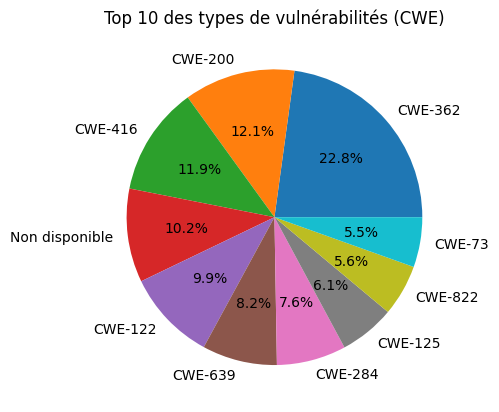

In [43]:
# -----------------------
# 2) Diagramme circulaire des CWE
# -----------------------

plt.figure()
df["Type CWE"].value_counts().head(10).plot.pie(autopct="%1.1f%%")
plt.title("Top 10 des types de vulnérabilités (CWE)")
plt.ylabel("")
plt.show()

**Interprétation**: Ce diagramme circulaire présente les 10 types de vulnérabilités (CWE - Common Weakness Enumeration) les plus fréquents dans les bulletins ANSSI. Les CWE identifient les catégories de faiblesses logicielles (ex: injection SQL, buffer overflow, XSS). Cette visualisation permet de comprendre quels types de vulnérabilités sont les plus répandus dans les produits analysés, ce qui peut orienter les priorités de sécurité et les mesures de protection à mettre en place.

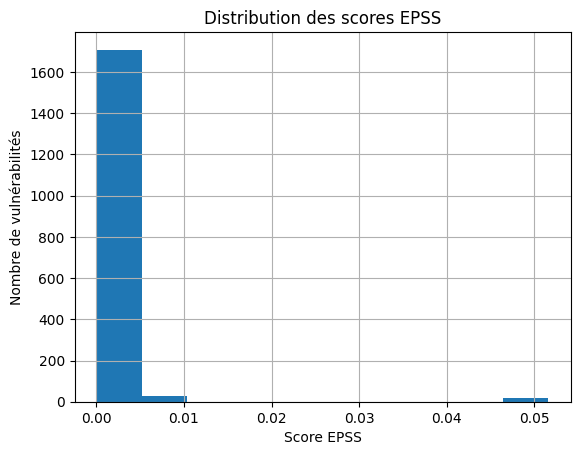

In [44]:
# -----------------------
# 3) Distribution EPSS
# -----------------------

plt.figure()
df["Score EPSS"].dropna().hist(bins=10)
plt.title("Distribution des scores EPSS")
plt.xlabel("Score EPSS")
plt.ylabel("Nombre de vulnérabilités")
plt.show()

**Interprétation**: L'histogramme des scores EPSS (Exploit Prediction Scoring System) montre la probabilité qu'une vulnérabilité soit exploitée dans les 30 prochains jours, sur une échelle de 0 à 1. Un score EPSS élevé (>0.5) indique un risque d'exploitation élevé. Cette distribution complète l'analyse CVSS en ajoutant une dimension temporelle et probabiliste. Une concentration dans les scores élevés suggère que les vulnérabilités identifiées présentent un risque d'exploitation actif, nécessitant une attention prioritaire.

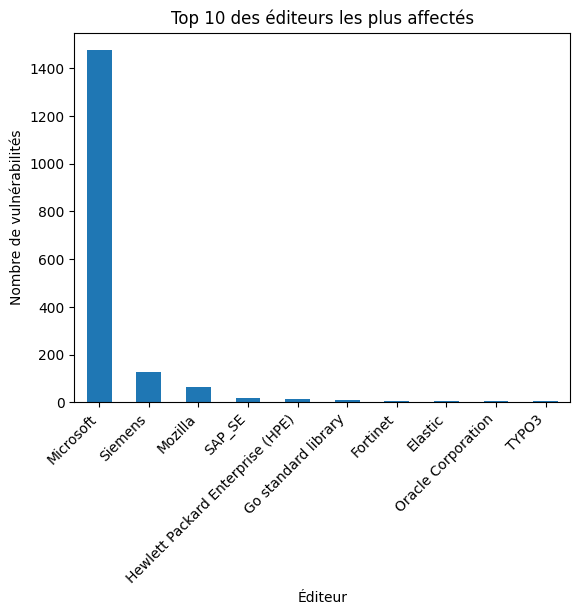

In [45]:

# -----------------------
# 4) Top éditeurs les plus affectés
# -----------------------

top_vendors = df["Éditeur/Vendor"].value_counts().head(10)

plt.figure()
top_vendors.plot.bar()
plt.title("Top 10 des éditeurs les plus affectés")
plt.xlabel("Éditeur")
plt.ylabel("Nombre de vulnérabilités")
plt.xticks(rotation=45, ha="right")
plt.show()

**Interprétation**: Ce graphique en barres identifie les 10 éditeurs/vendeurs de logiciels les plus fréquemment mentionnés dans les bulletins ANSSI. Cela permet d'identifier quels fournisseurs sont les plus touchés par les vulnérabilités signalées. Cette information est cruciale pour les organisations qui utilisent ces produits, car elle indique où concentrer les efforts de veille et de mise à jour de sécurité. Les éditeurs en tête de liste nécessitent une attention particulière.

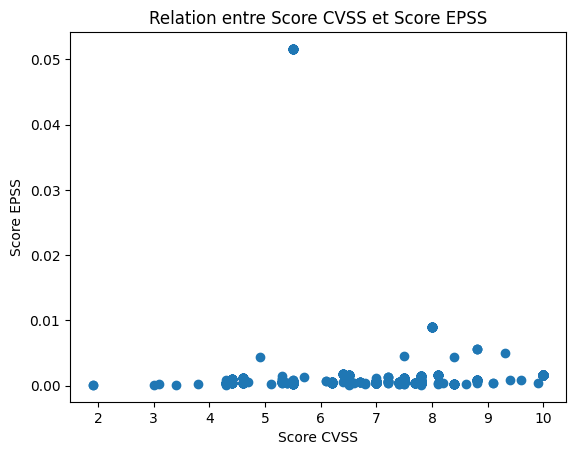

In [46]:

# -----------------------
# 5) Nuage de points CVSS vs EPSS
# -----------------------

plt.figure()
plt.scatter(df["Score CVSS"], df["Score EPSS"])
plt.title("Relation entre Score CVSS et Score EPSS")
plt.xlabel("Score CVSS")
plt.ylabel("Score EPSS")
plt.show()

**Interprétation**: Ce nuage de points explore la relation entre les scores CVSS (sévérité technique) et EPSS (probabilité d'exploitation). Une corrélation positive suggère que les vulnérabilités les plus sévères sont aussi les plus susceptibles d'être exploitées. Cependant, une faible corrélation indique que certaines vulnérabilités peuvent être sévères mais peu exploitées, ou inversement. Les points dans le quadrant supérieur droit (CVSS élevé + EPSS élevé) représentent les vulnérabilités les plus critiques nécessitant une action immédiate.

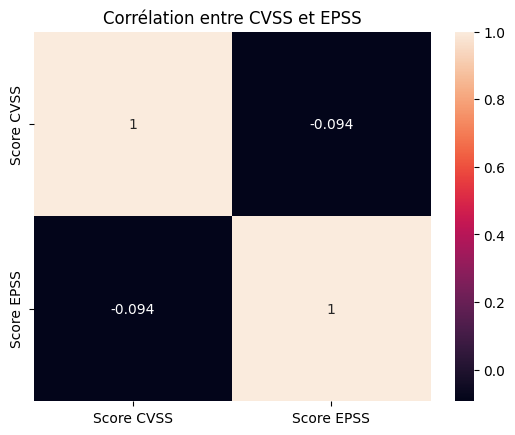

In [47]:
# -----------------------
# 6) Heatmap corrélation CVSS / EPSS
# -----------------------
plt.figure()
corr = df[["Score CVSS", "Score EPSS"]].corr()
sns.heatmap(corr, annot=True)
plt.title("Corrélation entre CVSS et EPSS")
plt.show()

**Interprétation**: Cette heatmap de corrélation quantifie la relation linéaire entre CVSS et EPSS. Un coefficient proche de 1 indique une forte corrélation positive (les scores évoluent dans le même sens), proche de -1 une corrélation négative, et proche de 0 une absence de corrélation. Cette mesure statistique complète l'analyse visuelle du nuage de points et permet de déterminer si les deux métriques sont complémentaires ou redondantes dans l'évaluation des risques.

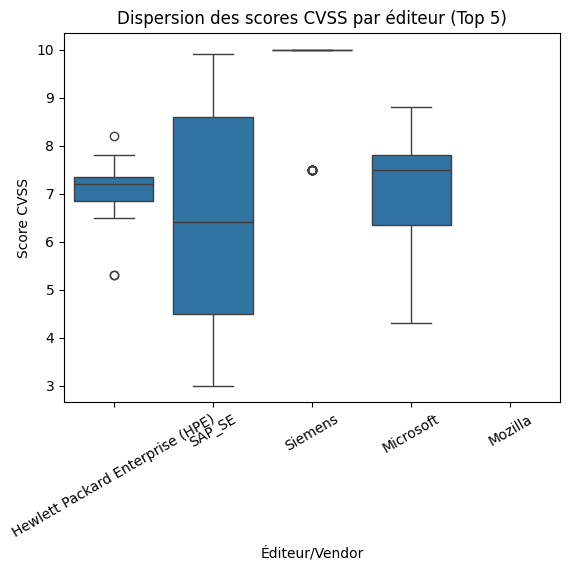

In [48]:
# -----------------------
# 7) Boxplot CVSS par éditeur (top 5)
# -----------------------

top5_vendors = df["Éditeur/Vendor"].value_counts().head(5).index
df_top5 = df[df["Éditeur/Vendor"].isin(top5_vendors)]

plt.figure()
sns.boxplot(x="Éditeur/Vendor", y="Score CVSS", data=df_top5)
plt.title("Dispersion des scores CVSS par éditeur (Top 5)")
plt.xticks(rotation=30)
plt.show()

**Interprétation**: Ce boxplot compare la distribution des scores CVSS pour les 5 éditeurs les plus affectés. Il montre la médiane, les quartiles, et les valeurs aberrantes pour chaque éditeur. Cela permet d'identifier si certains éditeurs ont tendance à avoir des vulnérabilités plus ou moins sévères en moyenne. Un boxplot avec une médiane élevée et une boîte large indique un éditeur avec des vulnérabilités globalement plus critiques et une grande variabilité dans la sévérité.

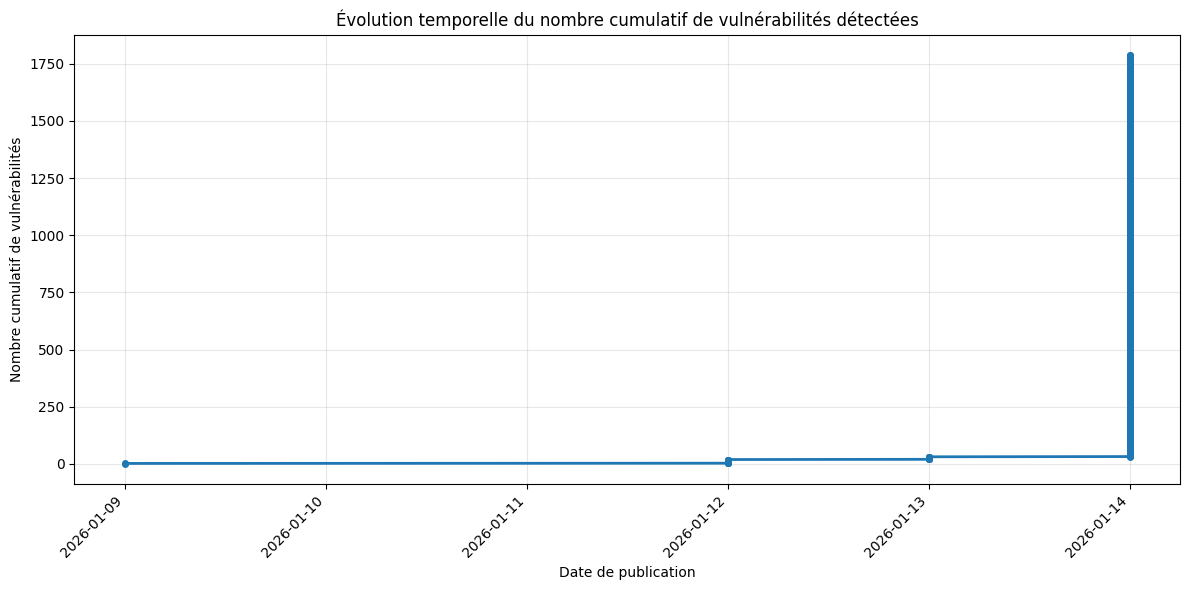


Période analysée : 2026-01-09 00:00:00+00:00 à 2026-01-14 00:00:00+00:00
Nombre total de vulnérabilités : 1787


In [49]:
# -----------------------
# 8) Courbe cumulative des vulnérabilités en fonction du temps
# -----------------------

# Conversion de la date en datetime
df["Date publication"] = pd.to_datetime(df["Date publication"], errors="coerce")

# Suppression des lignes avec dates invalides
df_dates = df.dropna(subset=["Date publication"]).copy()

# Tri par date
df_dates = df_dates.sort_values("Date publication")

# Calcul du cumul (nombre cumulatif de vulnérabilités)
df_dates["Cumul"] = range(1, len(df_dates) + 1)

# Création du graphique
plt.figure(figsize=(12, 6))
plt.plot(df_dates["Date publication"], df_dates["Cumul"], marker="o", linewidth=2, markersize=4)
plt.title("Évolution temporelle du nombre cumulatif de vulnérabilités détectées")
plt.xlabel("Date de publication")
plt.ylabel("Nombre cumulatif de vulnérabilités")
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

print(f"\nPériode analysée : {df_dates['Date publication'].min()} à {df_dates['Date publication'].max()}")
print(f"Nombre total de vulnérabilités : {len(df_dates)}")

**Interprétation**: Cette courbe cumulative montre l'évolution temporelle du nombre total de vulnérabilités détectées dans les bulletins ANSSI. La courbe croissante indique l'accumulation des vulnérabilités au fil du temps. Une pente raide suggère une période d'activité intense avec de nombreuses vulnérabilités découvertes, tandis qu'une pente douce indique une période plus calme. Cette visualisation permet d'identifier les tendances temporelles, les périodes critiques, et d'évaluer si le rythme de découverte de vulnérabilités s'accélère ou se stabilise. Elle est utile pour la planification des ressources de sécurité et la compréhension de l'évolution du paysage des menaces.

In [50]:
# -----------------------
# 9) Vulnérabilités critiques (CVSS ≥ 9)
# -----------------------
critical = df[df["Score CVSS"] >= 9]

print("\nNombre de vulnérabilités CRITIQUES (CVSS ≥ 9) :", len(critical))
print(critical[[
    "Identifiant CVE",
    "Score CVSS",
    "Score EPSS",
    "Éditeur/Vendor",
    "Produit"
]].head(10))


Nombre de vulnérabilités CRITIQUES (CVSS ≥ 9) : 114
    Identifiant CVE  Score CVSS  Score EPSS Éditeur/Vendor  \
70    CVE-2026-0491         9.1     0.00044         SAP_SE   
77    CVE-2026-0498         9.1     0.00044         SAP_SE   
79    CVE-2026-0500         9.6     0.00085         SAP_SE   
80    CVE-2026-0501         9.9     0.00047         SAP_SE   
96   CVE-2025-40805        10.0     0.00169        Siemens   
97   CVE-2025-40805        10.0     0.00169        Siemens   
98   CVE-2025-40805        10.0     0.00169        Siemens   
99   CVE-2025-40805        10.0     0.00169        Siemens   
100  CVE-2025-40805        10.0     0.00169        Siemens   
101  CVE-2025-40805        10.0     0.00169        Siemens   

                                               Produit  
70                        SAP Landscape Transformation  
77          SAP S/4HANA (Private Cloud and On-Premise)  
79   SAP Wily Introscope Enterprise Manager (WorkSt...  
80   SAP S/4HANA Private Cloud and O

# Conclusion

- Les CVE ont été enrichies avec MITRE et EPSS.
- Les scores CVSS et EPSS permettent de prioriser les vulnérabilités.
- Les produits et éditeurs les plus touchés sont clairement identifiés.
- La distribution temporelle montre les périodes actives des bulletins ANSSI.
- Ce notebook peut maintenant servir de base pour un reporting automatisé ou tableau de bord.
